## [Proyecto] Google Play Store apps y reviews

<p> Las aplicaciones mobiles estan por todos lados. Son faciles de crear y lucrativas. Debido a estos dos factores, cada vez se desarrollan más aplicaciones. En este cuaderno, haremos un análisis del mercado de aplicaciones de Android comparando más de diez mil aplicaciones en Google Play en diferentes categorías. Buscaremos ideas en los datos para idear estrategias que impulsen el crecimiento y la retención.</p>

<p>Archivos utilizados:</p>
<ul>
<li><code>apps.csv</code>: contiene todos los detalles de las apps (10 mil+) en Google Play. Hay 13 características que describen una determinada app.</li>
<li><code>user_reviews.csv</code>: contiene 100 reseñas para cada aplicación. Entre las características de estas podemos encontrar: Sentimiento (Positivo, Negativo o Neutral), Polaridad del Sentimiento y Subjetividad del Sentimiento.</li>
</ul>

## 1. Importación de los datos

In [31]:
import pandas as pd
# Carga los datos, estos contienen duplicados
apps_con_duplicados = pd.read_csv('datasets/apps.csv')

# Elimina los duplicados de apps_con_duplicados
apps = apps_con_duplicados.drop_duplicates()

# Muestra el número total de apps
print('Número total de aplicaciones en la base de datos = ', len(apps_con_duplicados))

# Echa un vistazo a una muestra aleatoria de 5 filas y todas las columnas
print(apps_con_duplicados.sample(5))

Número total de aplicaciones en la base de datos =  9659
      Unnamed: 0                 App       Category  Rating  Reviews  Size  \
4403        5359  I am rich(premium)        FINANCE     3.5      472   1.0   
6980        8045               CX-60         FAMILY     3.1       19  94.0   
2038        2580  Kate Mobile for VK         SOCIAL     4.4   540930   5.3   
2935        3692     OnePlus Gallery  VIDEO_PLAYERS     3.8     5555  64.0   
7020        8086           Cy-Reader         FAMILY     4.8       17  15.0   

         Installs  Type    Price Content Rating                   Genres  \
4403       5,000+  Paid  $399.99       Everyone                  Finance   
6980       1,000+  Free        0       Everyone                   Casual   
2038  10,000,000+  Free        0           Teen                   Social   
2935   1,000,000+  Free        0       Everyone  Video Players & Editors   
7020         100+  Free        0       Everyone                Education   

        Last Upda

## 2. Limpieza de Datos/Data cleaning

<p>Al observar una muestra aleatoria de la base de datos, observamos que algunas entradas de las columnas como <code> Installs</code> (Descargas) y <code>Price </code>(Precio) tienen algunos caracteres especiales (<code>+</code> <code>,</code> <code>$</code>) debido a la forma en que se han representado los números. Esto impide que las columnas sean puramente numéricas, lo que dificulta su uso en futuros cálculos matemáticos. Por esto procederemos a realizar arreglos para que estas columnas contengan sólo dígitos de [0-9].</p>
<p>En particular, removeremos los caracteres <code>,</code> y <code>+</code> en la columna <code>Installs</code> y <code>$</code> en la columna <code>Price</code></p>

In [32]:
# Lista de caracteres a remover
caracteres_a_remover = ['+', ',', '$']
# Lista de columnas por limpiar
cols_a_limpiar = ['Installs' , 'Price']

# Loop para cada columna en cols_a_limpiar
for col in cols_a_limpiar:
    # Loop para cada caracter en caracteres_a_remover
    for char in caracteres_a_remover:
        # Remplaza cada caracter por una string vacia
        apps[col] = apps[col].apply(lambda x: x.replace(char, ''))
        
# Muestra resumen de las columnas (incluye el tipo)
print(apps.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9659 entries, 0 to 9658
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      9659 non-null   int64  
 1   App             9659 non-null   object 
 2   Category        9659 non-null   object 
 3   Rating          8196 non-null   float64
 4   Reviews         9659 non-null   int64  
 5   Size            8432 non-null   float64
 6   Installs        9659 non-null   object 
 7   Type            9659 non-null   object 
 8   Price           9659 non-null   object 
 9   Content Rating  9659 non-null   object 
 10  Genres          9659 non-null   object 
 11  Last Updated    9659 non-null   object 
 12  Current Ver     9651 non-null   object 
 13  Android Ver     9657 non-null   object 
dtypes: float64(2), int64(2), object(10)
memory usage: 1.1+ MB
None


## 3. Corrección de data types
<p>Notamos que <code>Installs</code> y <code>Price</code> estan categorizados como tipo <code>object</code> (y no como <code>int</code> o <code>float</code>) debido a que estos contenian caracteres especiales.</p>
<p>Procedemos a cambiar los tipos a float</p>

In [33]:
import numpy as np

# Convierte Installs a float data type
apps['Installs'] = apps['Installs'].astype(float)

# Convierte Price a float data type
apps['Price'] = apps['Price'].astype(float)

# Chequea dtypes para confirmar los cambios en Installs y Price
print(apps.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9659 entries, 0 to 9658
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      9659 non-null   int64  
 1   App             9659 non-null   object 
 2   Category        9659 non-null   object 
 3   Rating          8196 non-null   float64
 4   Reviews         9659 non-null   int64  
 5   Size            8432 non-null   float64
 6   Installs        9659 non-null   float64
 7   Type            9659 non-null   object 
 8   Price           9659 non-null   float64
 9   Content Rating  9659 non-null   object 
 10  Genres          9659 non-null   object 
 11  Last Updated    9659 non-null   object 
 12  Current Ver     9651 non-null   object 
 13  Android Ver     9657 non-null   object 
dtypes: float64(4), int64(2), object(8)
memory usage: 1.1+ MB
None


## 4. Análisis exploratorio de las categorías

<p>En esta sección me enfoco en responder las siguientes preguntas:</p>
<ul>
<li>¿Qué categoría tiene la mayor cantidad de aplicaciones (activas) en el mercado? </li>
<li>¿Hay alguna categoría que domine el mercado?</li>
<li>¿Qué categorías tienen el menor número de aplicaciones?</li>
</ul>
<p>El análisis conluye que de las <code>33</code> categorías únicas en la base de datos, apps de <em>Family</em> (Familia) y <em>Game</em> (Juegos) tienen la mayor prevalencia en el mercado, pero apps de <em>Tools</em> (Herramientas), <em>Business</em> (Negocios) y <em>Medical</em> (Medicina) también se encuentran dentro del top.</p>

In [34]:
import plotly
plotly.offline.init_notebook_mode(connected=True)

import plotly.graph_objs as go

# Muestra número total de categorías unicas
num_categories = len(apps['Category'].unique())
print('Número de categorías = ', num_categories)

# Cuenta el número total de apps por categoría. 
num_apps_por_categoria = apps['Category'].value_counts()
                                                
# Ordena num_apps_por_categoria en orden descendente
ordenado_num_apps_por_categoria = num_apps_por_categoria.sort_values(ascending = False)

data = [go.Bar(
        x = num_apps_por_categoria.index, # index = nombre de la categoría
        y = num_apps_por_categoria.values, # valores = número de apps
)]

plotly.offline.iplot(data)


Número de categorías =  33


## 5. Distribución de las app reviews
<p>Las reviews influyen en la posibilidad de las apps de ser descubiertas, en su conversión y en la imagen de la empresa, por esto las reviews son un indicador clave en rendimiento de una aplicación.</p>
<p>Tras el cálculo, descubrimos que el rating promedio de reviews en todas las categorías de aplicaciones es de <code>4,17</code>. El histograma está expuesto hacia la derecha, lo que indica que la mayoría de las aplicaciones están muy bien valoradas, con solo unas pocas excepciones de aplicaciones poco valoradas.</p>

In [35]:
#  Obtiene rating promedio de todas las apps
promedio_app_rating = apps['Rating'].mean()
print('Rating total promedio = ', promedio_app_rating)

# Histograma de las apps de acuerdo con sus ratings
data = [go.Histogram(
        x = apps['Rating']
)]

# Vertical dashed line to indicate the average app rating
layout = {'shapes': [{
              'type' :'line',
              'x0': promedio_app_rating,
              'y0': 0,
              'x1': promedio_app_rating,
              'y1': 1000,
              'line': { 'dash': 'dashdot'}
          }]
          }

plotly.offline.iplot({'data': data, 'layout': layout})

Rating total promedio =  4.173243045387994


## 6. Análisis tamaño y precio de las apps
<p>Esta sección examina el tamaño y el precio de las apps. En cuanto al tamaño, si la aplicación móvil es demasiado grande, puede resultar difícil y/o costosa de descargar para los usuarios. Los largos tiempos de descarga pueden hacer que los usuarios se desentiendan de su aplicación móvil antes de que la experimenten. Además, el dispositivo de cada usuario tiene una cantidad limitada de almacenamiento. En cuanto al precio, algunos usuarios esperan que sus aplicaciones sean gratuitas o baratas.</p>
<p>Por esto esta parte busca responder las siguientes preguntas: </p>
<p>¿Cómo podemos elaborar estrategias eficaces para fijar el precio de una app?</p>
<ul>
<li>¿Afecta el tamaño de una app a su calificación/rating? </li>
<li>¿Los usuarios realmente se preocupan por las aplicaciones de gran peso en el sistema o prefieren las aplicaciones ligeras?</li>
<li>¿Influye el precio de una aplicación en su valoración? </li>
<li>¿Los usuarios prefieren las aplicaciones gratuitas a las de pago?</li>
</ul>
<p>Tras nuestros cálculos y análisis, encontramos que la mayoría de las aplicaciones mejor valoradas (con una puntuación superior a 4) son livianas con un peso entre 2 y 20 MB. También encontramos que la gran mayoría de las aplicaciones tienen un precio inferior a 10 euros..</p>

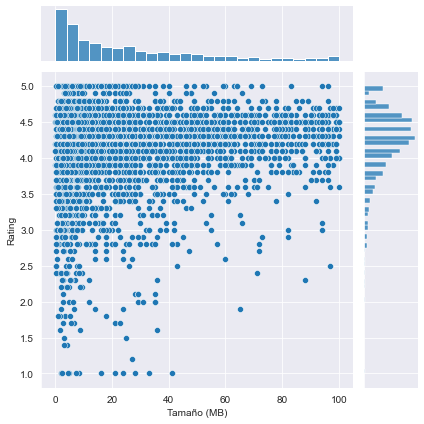

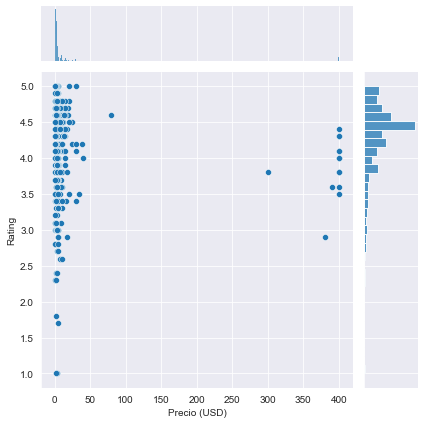

In [36]:
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import warnings
warnings.filterwarnings("ignore")

# Selecciona las filas en las que están presentes los valores "Rating" y "Size" (es decir, los dos valores no son nulos)
apps_con_tamano_y_rating_presente = apps[(apps['Rating'].notnull()) & (apps['Size'].notnull())]

# Subconjunto de categorías con al menos 250 aplicaciones activas
grandes_categorias = apps_con_tamano_y_rating_presente.groupby(['Category']).filter(lambda x: len(x) >= 250)

# Gráfico Tamaño vs. Rating
plt1 = sns.jointplot(x = grandes_categorias['Size'], y = grandes_categorias['Rating'])
plt1.set_axis_labels('Tamaño (MB)', 'Rating')
# Selecciona las app de pago
paid_apps = apps_con_tamano_y_rating_presente[apps_con_tamano_y_rating_presente['Type'] == 'Paid']

# Gráfico Precio vs. Rating
plt2 = sns.jointplot(x = paid_apps['Price'], y = paid_apps['Rating'])
plt2.set_axis_labels('Precio (USD)', 'Rating')

## 7. Relación entre la categoría de la app y su precio

<p> Esta parte examina la distribución de precio según cada categoría. El objetivo es identificar que categorías tienden a tener un valor elevado y cuáles son mayoritariamente baratas o gratis. A continuación, vemos que las aplicaciones médicas y familiares son las más caras. Algunas aplicaciones médicas alcanzan hasta los 80 dólares. Por otro lado, las aplicaciones de juegos tienen un precio principalmente por debajo de los 20 dólares.</p>

<p>Ya que el gráfico muestra apps con precios muy elvenados, las filtramos y esto resulta en una lista de apps 'basura', que utilizan precios elevados para llamar la atención, estas serán filtradas en la siguiente sección </p>

,Category,App,Price
3327,FAMILY,most expensive app (H),399.99
3465,LIFESTYLE,💎 I'm rich,399.99
3469,LIFESTYLE,I'm Rich - Trump Edition,400.00
4396,LIFESTYLE,I am rich,399.99
4398,FAMILY,I am Rich Plus,399.99
4399,LIFESTYLE,I am rich VIP,299.99
4400,FINANCE,I Am Rich Premium,399.99
4401,LIFESTYLE,I am extremely Rich,379.99
4402,FINANCE,I am Rich!,399.99
4403,FINANCE,I am rich(premium),399.99


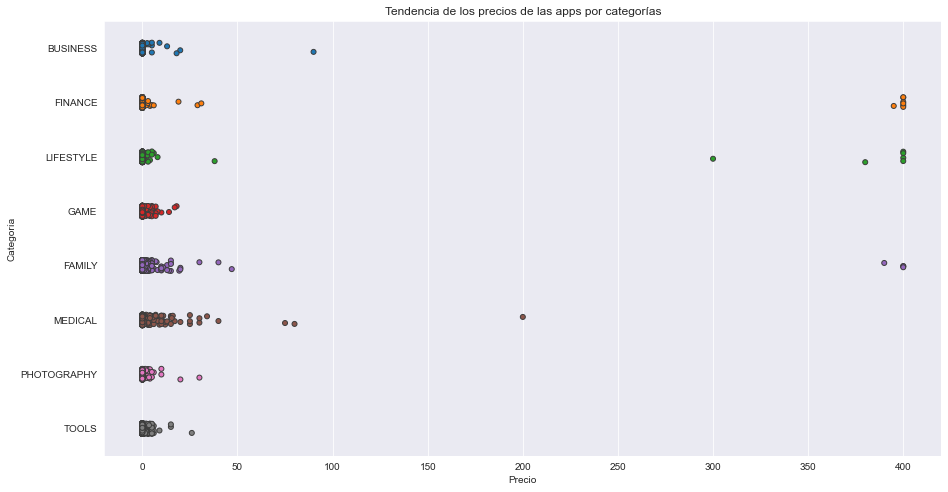

In [37]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)

# Selecciona apps de las categorías populares
popular_app_cats = apps[apps.Category.isin(['GAME', 'FAMILY', 'PHOTOGRAPHY',
                                            'MEDICAL', 'TOOLS', 'FINANCE',
                                            'LIFESTYLE','BUSINESS'])]

# Gráfico Precio vs Categoría
ax = sns.stripplot(x = popular_app_cats['Price'], y = popular_app_cats['Category'], jitter=True, linewidth=1)
ax.set_title('Tendencia de los precios de las apps por categorías')
ax.set_xlabel('Precio')
ax.set_ylabel('Categoría')
# Apps con precio mayor a $200
apps_mayor_200 = popular_app_cats[popular_app_cats['Price'] >  200]
apps_mayor_200[['Category', 'App', 'Price']]

## 8. Filtrado de Apps 'Basura'
<p>Ya que estas apps son creadas principalmente para llamar la atención, sin aportar un claro servicio real, serán descartadas y realizamos nuevamente el gráfico.</p>

,Category,App,Price
8588,BUSINESS,Lean EQ,89.99
1755,MEDICAL,Vargo Anesthesia Mega App,79.99
1881,MEDICAL,Language Therapy: Aphasia,74.99
5545,FAMILY,Dr.Dice - Sic bo analyzer,46.99
1896,MEDICAL,LTC AS Legal,39.99
3275,FAMILY,Norwegian For Kids & Babies F,39.99
4404,LIFESTYLE,I am Rich Person,37.99
1803,MEDICAL,A Manual of Acupuncture,33.99
8751,FINANCE,Eu sou Rico,30.99


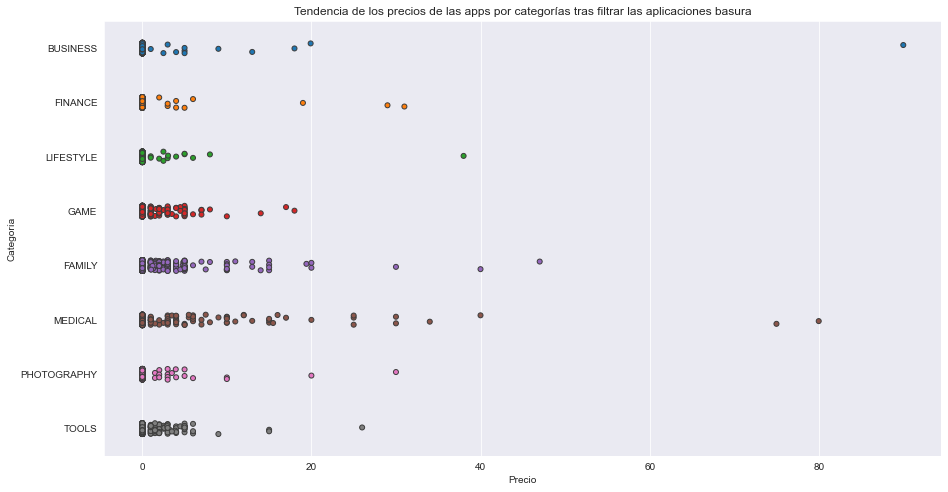

In [38]:
# Selecciona apps bajo $100
apps_bajo_100 = popular_app_cats[popular_app_cats['Price'] < 100]

fig, ax = plt.subplots()
fig.set_size_inches(15, 8)

# Examina el precio por categoría de apps auténticas (apps_bajo_100)
ax = sns.stripplot(x = apps_bajo_100['Price'], y = apps_bajo_100['Category'], data = apps_bajo_100, jitter = True, linewidth = 1)
ax.set_title('Tendencia de los precios de las apps por categorías tras filtrar las aplicaciones basura')
ax.set_xlabel('Precio')
ax.set_ylabel('Categoría')
# Muestra nuevamente las apps mas caras
top_apps_precio = apps_bajo_100[apps_bajo_100['Price'] >  30]
ordenado_top_apps_precio = top_apps_precio.sort_values('Price', ascending= False)
ordenado_top_apps_precio[['Category', 'App', 'Price']]

## 9. Popularidad de las apps de pago frente a las gratuitas
<p>Este análisis busca responder las siguientes preguntas:</p>
<p>¿Se descargan las aplicaciones de pago tanto como las gratuitas?

Los resultados apuntan a que las aplicaciones de pago tienen un número relativamente menor de instalaciones que las aplicaciones gratuitas, aunque la diferencia no es tan marcada como se habría esperado.</p>

In [39]:
trace0 = go.Box(
    # Datos de las apps pagas
    y = apps[apps['Type'] == 'Paid']['Installs'],
    name = 'Pagada'
)

trace1 = go.Box(
    # Datos de las apps gratis
    y = apps[apps['Type'] == 'Free']['Installs'],
    name = 'Gratis'
)

layout = go.Layout(
    title = "Número de descargas de apps pagadas vs. apps gratuitas",
    yaxis = dict(title = "Log número de descargas",
                type = 'log',
                autorange = True)
)

# Añade trace0 y trace1 al gráfico
data = [trace0, trace1]
plotly.offline.iplot({'data': data, 'layout': layout})

## 10. Análisis del sentimiento de las opiniones de los usuarios
<p>Para determinar cómo se siente la gente con respecto a las apps utilizamos los resultados de la técnica análisis de sentimientos en la reviews de la base de datos.</p>
<p> Tras analizar los comentarios de los usuarios de las aplicaciones de pago y gratuitas, observamos que las aplicaciones gratuitas reciben muchos comentarios duros, como indican los valores atípicos en el eje negativo. Los comentarios de las aplicaciones de pago no parecen ser nunca extremadamente negativos. Esto puede indicar algo sobre la calidad de la aplicación, es decir, que las aplicaciones de pago tienden a tener mayor calidad que las gratuitas en promedio. La mediana de la puntuación de polaridad de las aplicaciones de pago es un poco más alta que la de las gratuitas, lo que coincide con nuestra observación anterior.</p>


[Text(0, 0, 'Gratis'), Text(1, 0, 'Pagada')]

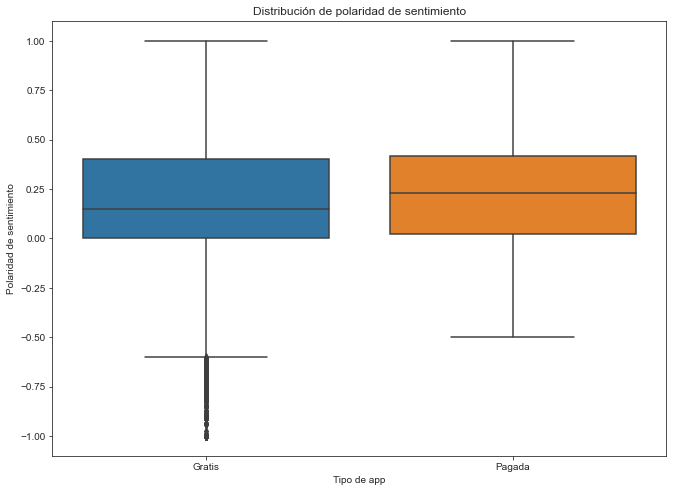

In [40]:
# Carga las reviews de usuarios: user_reviews.csv
reviews_df = pd.read_csv('datasets/user_reviews.csv')

# Une ambas tablas
merged_df = pd.merge(apps, reviews_df, on = "App")

# Elimina filas con valores nulos de las columnas Sentiment (Sentimiento) y Review
merged_df = merged_df.dropna(subset = ['Sentiment', 'Review'])

sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)

# Gráfico polaridad de sentimiento en las reviews de apps de pago vs. gratuitas
ax = sns.boxplot(x = 'Type', y = 'Sentiment_Polarity', data = merged_df)
ax.set_title('Distribución de polaridad de sentimiento')
ax.set_ylabel('Polaridad de sentimiento')
ax.set_xlabel('Tipo de app')
ax.set_xticklabels(('Gratis','Pagada'))